In [2]:
from image.segmentation import BasicImageSegmenter
from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

from cfg import *

from livelossplot import PlotLossesKerasTF

import os
print(os.getcwd())
os.chdir('/home/jelinek/recetox/')


model_name = 'ResNet50_ImagenetWeightsTrainLast-128'

2022-02-12 23:47:34.846768: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-12 23:47:34.846802: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-12 23:47:34.866203: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-12 23:47:34.925592: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-02-12 23:47:34.926046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-02-12 23:47:34.936359: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-02-12 23:47:34.950862: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-02-12 23:47:34.950991: I tensorflow/c

/home/jelinek/recetox/src/notebooks


In [2]:
from keras_preprocessing.image import ImageDataGenerator


class MyResNet50(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params. name = model_name
        self.params.batch_size = 16
        self.params.tile_size = 128

        lr_schedule = schedules.ExponentialDecay(
                        initial_learning_rate=1e-1,
                        decay_steps=80,
                        decay_rate=0.1,
                        staircase=True)

        self.optimizer = ( Adam(
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999))


    @staticmethod
    def get_compiled_model():
        base_model = ResNet50(include_top=False,
                      input_shape=(128, 128, 3),
                      weights='imagenet',
                      pooling=None
                      )
        base_model.trainable = False

        inputs = keras.Input(shape=(128, 128, 3))
        x = base_model(inputs, training=False)
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        outputs = keras.layers.Dense(12, activation='softmax', name='probs')(x)

        model = keras.Model(inputs, outputs)

        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True, height_shift_range=0.1, width_shift_range=0.1)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                             class_mode='categorical', batch_size=self.params.batch_size,
                                             shuffle=True,
                                             target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_datagen_segmentation(self):
        return ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=5,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

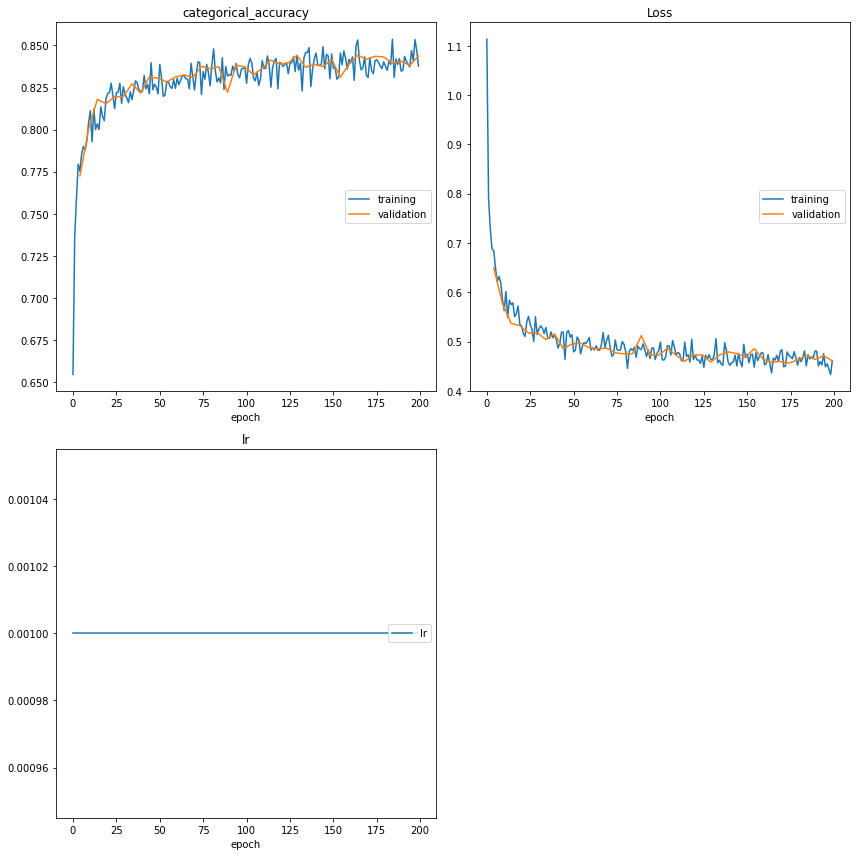

categorical_accuracy
	training         	 (min:    0.655, max:    0.854, cur:    0.838)
	validation       	 (min:    0.773, max:    0.844, cur:    0.844)
Loss
	training         	 (min:    0.433, max:    1.114, cur:    0.461)
	validation       	 (min:    0.456, max:    0.649, cur:    0.461)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
924/924 [==============================] - 16s 17ms/step - loss: 0.4606 - categorical_accuracy: 0.8438
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4303ms
Confusion Matrix
[[3149   30   86    4   69    0   26    7    0    0  198    3]
 [ 116  380  111    3   26    0   62   22    0    2   21    0]
 [  98   24 1134    0   66    0  114   24    0    1   17    0]
 [   0    1    0   79    9    0    0    0    0    0    0    0]
 [  11    3   18   30 5115    0    2    0    0    0   12    0]
 [   2    0    0    0    0    6    0    0    0    0    1    0]
 [  39   23  116    0    3    0  547   22    0    0   15    0]
 [  

In [3]:
pipeline = MyResNet50(train_data_dir='data/Feit_colon-annotation-tiles-128/data_train/',
                      valid_data_dir='data/Feit_colon-annotation-tiles-128/data_valid/')

pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [4]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [5]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=False)

Found 14784 images belonging to 12 classes.
924/924 [==============================] - 15s 17ms/step - loss: 0.4606 - categorical_accuracy: 0.8438
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3530ms
Confusion Matrix
[[3149   30   86    4   69    0   26    7    0    0  198    3]
 [ 116  380  111    3   26    0   62   22    0    2   21    0]
 [  98   24 1134    0   66    0  114   24    0    1   17    0]
 [   0    1    0   79    9    0    0    0    0    0    0    0]
 [  11    3   18   30 5115    0    2    0    0    0   12    0]
 [   2    0    0    0    0    6    0    0    0    0    1    0]
 [  39   23  116    0    3    0  547   22    0    0   15    0]
 [  25    9   63    0    9    0   32  647    0    0   16    0]
 [   1    1    0    0    0    0    2    0    2    0    0    0]
 [   0    1    7    0    0    0    2    0    0    0    0    0]
 [ 503   18   33    1   76    1   12    5    0    1 1407    0]
 [  20    0    1    2    2    0    0    0    0    0   30    8]]
Cla

In [3]:
pipeline = FeitDataPipeline.load_pipeline(model_name)


2022-02-12 23:47:44.431295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 23:47:44.431447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 23:47:44.431496: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 23:47:44.463469: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-12 23:47:44.463586: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-12 23:47:44.502322: I tensorflow/stream_exec

In [ ]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / model_name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 1 out of 437

2022-02-12 23:47:47.790871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-12 23:47:47.815830: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399905000 Hz
2022-02-12 23:47:48.660009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-12 23:47:49.462512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-02-12 23:47:50.538943: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-12 23:47:50.538968: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-02-12 23:47:50.539687: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-12 23:47:50.539761: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

Processing region 437 out of 437
Processing image took 1787.3026812076569 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-128/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 1020 out of 1020
Processing image took 4319.661900758743 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-128/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 990 out of 990
Processing image took 4187.965584039688 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-128/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 210 out of 210
Processing image took 828.2323477268219 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-128/ns-adenoca-colon-lupos-15071-2019-20x-he-14.tiff
Processing region 2268 out of 2268
Processing image took 9433.142587184906 seconds
